# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

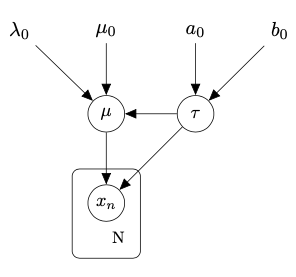

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [105]:
import numpy as np
def generate_data(mu, tau, N):
  np.random.seed(0)
  D = np.random.normal(mu, 1/np.sqrt(tau), N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



In [106]:
import matplotlib.pyplot as plt
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here

plt.hist(dataset_1, bins=30, alpha=0.5, label='N=10')
plt.savefig('Report/figures/1.2/dataset_1.png')
plt.clf()
plt.hist(dataset_2, bins=30, alpha=0.5, label='N=100')
plt.savefig('Report/figures/1.2/dataset_2.png')
plt.clf()
plt.hist(dataset_3, bins=30, alpha=0.5, label='N=1000')
plt.savefig('Report/figures/1.2/dataset_3.png')
plt.clf()


<Figure size 640x480 with 0 Axes>

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [107]:
from scipy import stats
def ML_est(data):
  mu_ml, tau_ml = stats.norm.fit(data)
  # insert your code
  return mu_ml, tau_ml

In [108]:
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))


(2.043722377390312, 1.3676565361963386)
(1.0845813067074894, 1.4253607397532255)
(0.9359973504790137, 1.3958756795016913)


### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation

  return exact_post_dist_parameters

In [109]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):

    n = len(D)

    # Sample mean of data
    x_bar = np.mean(D)

    mu_n = (lambda_0 * mu_0 + n * x_bar) / (lambda_0 + n)
    lambda_n = lambda_0 + n
    a_n = a_0 + n / 2
    b_n = b_0 + 0.5 * np.sum((D - x_bar) ** 2) + (lambda_0 * n * (x_bar - mu_0) ** 2) / (2 * (lambda_0 + n))

    return mu_n, lambda_n, a_n, b_n



### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [110]:
# prior parameters
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [111]:
from scipy.special import digamma, gammaln
import numpy as np

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)  # Number of data points

    # Compute data statistics
    sum_x = np.sum(D)
    sum_x2 = np.sum(D**2)

    # Compute expectations under q
    E_tau = a_N / b_N
    E_log_tau = digamma(a_N) - np.log(b_N)
    E_mu = mu_N
    E_mu2 = mu_N**2 + 1 / lambda_N
    E_mu_mu0 = E_mu - mu_0
    E_mu_mu0_sq = E_mu_mu0**2 + 1 / lambda_N

    # Expected log likelihood
    E_log_likelihood = (
        N / 2 * (E_log_tau - np.log(2 * np.pi))
        - 0.5 * E_tau * (sum_x2 - 2 * E_mu * sum_x + N * E_mu2)
    )

    # Expected log prior of mu given tau
    E_log_p_mu_given_tau = (
        0.5 * (np.log(lambda_0) - np.log(2 * np.pi))
        + 0.5 * E_log_tau
        - 0.5 * lambda_0 * E_tau * (E_mu2 - 2 * mu_0 * E_mu + mu_0**2)
    )

    # Expected log prior of tau (corrected)
    E_log_p_tau = (
        (a_0 - 1) * E_log_tau
        - b_0 * E_tau
        + a_0 * np.log(b_0)   # Corrected sign here
        - gammaln(a_0)
    )

    # Total expected log prior
    E_log_prior = E_log_p_mu_given_tau + E_log_p_tau

    # Entropy of q(mu)
    H_q_mu = 0.5 * (1 + np.log(2 * np.pi) - np.log(lambda_N))

    # Entropy of q(tau)
    H_q_tau = (
        a_N
        - np.log(b_N)
        + gammaln(a_N)
        + (1 - a_N) * digamma(a_N)
    )

    # Compute the ELBO
    elbo = E_log_likelihood + E_log_prior + H_q_mu + H_q_tau
    return elbo


Now, implement the CAVI algorithm:

In [112]:
from scipy.special import digamma, gammaln
import numpy as np


def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=1000, tol=1e-6):
    N = len(D)
    sum_x = np.sum(D)
    sum_x2 = np.sum(D**2)
    
    # Initialize variational parameters
    a_N = a_0 + N / 2
    b_N = b_0 + 1  # Arbitrary initialization for b_N
    E_tau = a_N / b_N
    lambda_N = lambda_0 + N * E_tau
    mu_N = (lambda_0 * mu_0 + E_tau * sum_x) / lambda_N
    
    elbos = []
    
    for _ in range(max_iter):
        # Save current ELBO to check for convergence
        prev_elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        
        # Update mu_N using current E_tau
        mu_N = (lambda_0 * mu_0 + E_tau * sum_x) / (lambda_0 + N * E_tau)
        
        # Update lambda_N with the new E_tau
        lambda_N = lambda_0 + N * E_tau
        
        # Update E_mu2 and E_mu_mu0_sq with the new mu_N and lambda_N
        E_mu2 = mu_N**2 + 1 / lambda_N
        E_mu_mu0_sq = (mu_N - mu_0)**2 + 1 / lambda_N
        
        # Update b_N with the new E_mu2 and E_mu_mu0_sq
        b_N = b_0 + 0.5 * (sum_x2 - 2 * mu_N * sum_x + N * E_mu2) + 0.5 * lambda_0 * E_mu_mu0_sq
        
        # Update E_tau with the new b_N
        E_tau = a_N / b_N
        
        # Update ELBO with the updated parameters
        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)
        
        # Check for convergence
        if abs(elbo - prev_elbo) < tol:
            break
    
    return a_N, b_N, mu_N, lambda_N, elbos, _


Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


[-183.6607493166583, -182.18673854098688, -182.18682337893082, -182.1868244236176, -182.18682443380908, -182.18682443390833]
5


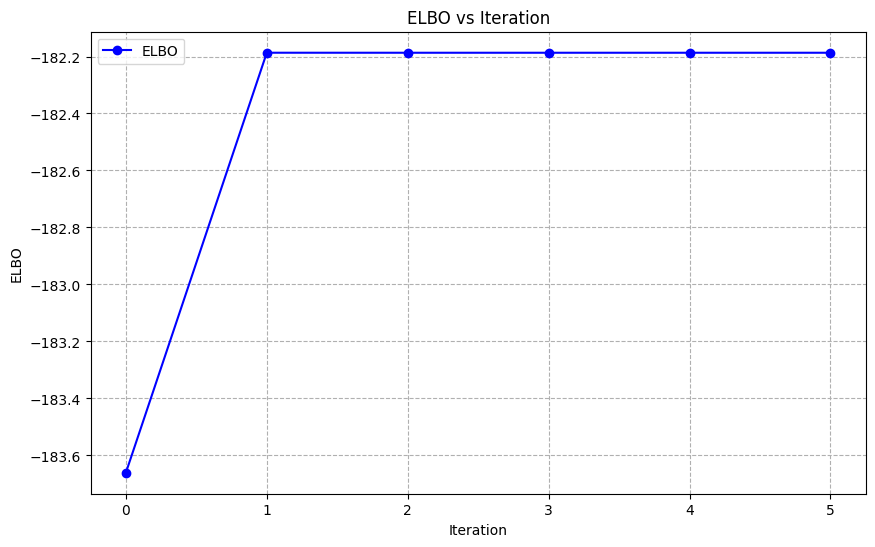

(1.0738428779282074, 101, 51.0, 103.16499687736406)
1.0628691750549684 49.95277866148911 51.0 104.1820329689298


<Figure size 640x480 with 0 Axes>

In [113]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

mu_ml, tau_ml = ML_est(dataset_3)
a_N, b_N, mu_N, lambda_N, elbos, iter = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0, max_iter=1000, tol=1e-10)
print(elbos)
print(iter)

plt.figure(figsize=(10, 6))
plt.plot(range(iter+1), elbos, label='ELBO', color='blue', marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO vs Iteration')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
plt.savefig('Report/figures/1.2/elbos.png')
plt.clf()

exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
print(exact_post_dist_param)
print(mu_N, lambda_N, a_N, b_N)


